# Advanced Grid Search Features

This notebook demonstrates advanced grid search capabilities including:

- **Vectorized strategy** for element-wise parameter pairing
- **Resume functionality** for continuing interrupted searches
- **Memory management** techniques for large parameter spaces
- **Multi-dimensional parameter optimization** with matrix parameters

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ASKabalan/jax-grid-search/blob/main/examples/02-advanced-grid-search.ipynb)

## Setup and Imports

In [61]:
# Install the package if running in Colab
try:
    import google.colab
    !pip install jax_grid_search
except ImportError:
    pass  # Not in Colab

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax_grid_search import DistributedGridSearch
import os
import shutil
import time
import glob
import jax

## 1. Vectorized vs Cartesian Strategies

The library supports two parameter combination strategies:
- **Cartesian** (default): Full cross-product of all parameters
- **Vectorized**: Element-wise pairing of parameters

Let's explore both approaches with a practical example.

In [62]:
def neural_network_objective(learning_rate, batch_size, dropout_rate, num_layers):
    """
    Simulated neural network hyperparameter optimization.
    
    This represents a realistic scenario where you might have
    correlated hyperparameters that work well together.
    """
    # Simulate training performance based on hyperparameters
    # Higher learning rates work better with larger batch sizes
    lr_batch_synergy = 1.0 - jnp.abs(jnp.log10(learning_rate) + jnp.log10(batch_size/100))
    
    # Optimal dropout depends on number of layers
    optimal_dropout = jnp.clip(0.1 + 0.05 * (num_layers - 2), 0.1, 0.5)
    dropout_penalty = (dropout_rate - optimal_dropout)**2
    
    # Combine factors (lower is better - we're minimizing)
    performance = dropout_penalty + 0.1 * (1 - lr_batch_synergy) + 0.01 * jnp.abs(num_layers - 4)
    
    return {
        "value": performance,
        "lr_batch_synergy": lr_batch_synergy,
        "dropout_penalty": dropout_penalty,
        "optimal_dropout": optimal_dropout
    }

# Test the function
test_result = neural_network_objective(0.01, 64, 0.2, 3)
print("Test result:", test_result)

Test result: {'value': Array(0.231882, dtype=float32), 'lr_batch_synergy': Array(-1.19382, dtype=float32), 'dropout_penalty': Array(0.0025, dtype=float32, weak_type=True), 'optimal_dropout': Array(0.15, dtype=float32, weak_type=True)}


### Cartesian Strategy (Default)
Creates all possible combinations of parameters - full factorial design.

In [63]:
# Define parameter space for cartesian strategy
cartesian_space = {
    "learning_rate": jnp.array([0.001, 0.01, 0.1]),
    "batch_size": jnp.array([32, 64, 128]),
    "dropout_rate": jnp.array([0.1, 0.2, 0.3]),
    "num_layers": jnp.array([2, 3, 4])
}

print("Cartesian Strategy:")
for param, values in cartesian_space.items():
    print(f"  {param}: {values}")

total_cartesian = 1
for values in cartesian_space.values():
    total_cartesian *= len(values)
print(f"\nTotal combinations (Cartesian): {total_cartesian}")

# Clean up and run cartesian search
if os.path.exists("results_cartesian"):
    shutil.rmtree("results_cartesian")

grid_cartesian = DistributedGridSearch(
    objective_fn=neural_network_objective,
    search_space=cartesian_space,
    strategy="cartesian",  # This is the default
    progress_bar=True,
    result_dir="results_cartesian",
    batch_size=20  # Process 20 combinations at a time
)

print("\nRunning Cartesian grid search...")
grid_cartesian.run()
results_cartesian = grid_cartesian.stack_results("results_cartesian")

print(f"Completed {len(results_cartesian['value'])} evaluations")
print(f"Best cartesian result: LR={results_cartesian['learning_rate'][0]}, "
      f"BS={results_cartesian['batch_size'][0]}, "
      f"DR={results_cartesian['dropout_rate'][0]}, "
      f"NL={results_cartesian['num_layers'][0]}, "
      f"Value={results_cartesian['value'][0]:.4f}")

Cartesian Strategy:
  learning_rate: [0.001 0.01  0.1  ]
  batch_size: [ 32  64 128]
  dropout_rate: [0.1 0.2 0.3]
  num_layers: [2 3 4]

Total combinations (Cartesian): 81
Process 0 will process 81 combinations with batch size 20

Running Cartesian grid search...


Processing batches on device 0/1: 100%|██████████| 5/5 [00:00<00:00, 40.87it/s]


Loading from 0 to 5 (batch size 5)


Converting to arrays: 100%|██████████| 8/8 [00:00<00:00, 1498.97it/s]

Completed 81 evaluations
Best cartesian result: LR=0.10000000149011612, BS=128, DR=0.20000000298023224, NL=4, Value=0.0893


### Vectorized Strategy
Element-wise pairing - useful when you have expert knowledge about parameter combinations that work well together.

In [64]:
# Define parameter space for vectorized strategy
# These are "expert-guided" combinations that might work well together
vectorized_space = {
    "learning_rate": jnp.array([0.1, 0.01, 0.001, 0.01, 0.001]),      # High to low
    "batch_size": jnp.array([32, 64, 128, 32, 64]),                   # Corresponding batch sizes
    "dropout_rate": jnp.array([0.1, 0.2, 0.3, 0.15, 0.25]),           # Tuned dropout rates
    "num_layers": jnp.array([2, 3, 4, 2, 3])                          # Corresponding depths
}

print("Vectorized Strategy (element-wise pairing):")
print("Combination pairs:")
for i in range(len(vectorized_space['learning_rate'])):
    print(f"  {i+1}: LR={vectorized_space['learning_rate'][i]}, "
          f"BS={vectorized_space['batch_size'][i]}, "
          f"DR={vectorized_space['dropout_rate'][i]}, "
          f"NL={vectorized_space['num_layers'][i]}")

print(f"\nTotal combinations (Vectorized): {len(vectorized_space['learning_rate'])}")

# Clean up and run vectorized search
if os.path.exists("results_vectorized"):
    shutil.rmtree("results_vectorized")

grid_vectorized = DistributedGridSearch(
    objective_fn=neural_network_objective,
    search_space=vectorized_space,
    strategy="vectorized",  # Element-wise pairing
    progress_bar=True,
    result_dir="results_vectorized",
    batch_size=10  # Process 10 combinations at a time
)

print("\nRunning Vectorized grid search...")
grid_vectorized.run()
results_vectorized = grid_vectorized.stack_results("results_vectorized")

print(f"Completed {len(results_vectorized['value'])} evaluations")
print(f"Best vectorized result: LR={results_vectorized['learning_rate'][0]}, "
      f"BS={results_vectorized['batch_size'][0]}, "
      f"DR={results_vectorized['dropout_rate'][0]}, "
      f"NL={results_vectorized['num_layers'][0]}, "
      f"Value={results_vectorized['value'][0]:.4f}")

Vectorized Strategy (element-wise pairing):
Combination pairs:
  1: LR=0.10000000149011612, BS=32, DR=0.10000000149011612, NL=2
  2: LR=0.009999999776482582, BS=64, DR=0.20000000298023224, NL=3
  3: LR=0.0010000000474974513, BS=128, DR=0.30000001192092896, NL=4
  4: LR=0.009999999776482582, BS=32, DR=0.15000000596046448, NL=2
  5: LR=0.0010000000474974513, BS=64, DR=0.25, NL=3

Total combinations (Vectorized): 5
Process 0 will process 5 combinations with batch size 5

Running Vectorized grid search...


Processing batches on device 0/1: 100%|██████████| 1/1 [00:00<00:00, 50.93it/s]


Loading from 0 to 1 (batch size 1)


Converting to arrays: 100%|██████████| 8/8 [00:00<00:00, 6627.38it/s]

Completed 5 evaluations
Best vectorized result: LR=0.10000000149011612, BS=32, DR=0.10000000149011612, NL=2, Value=0.1695


### Comparing Strategies

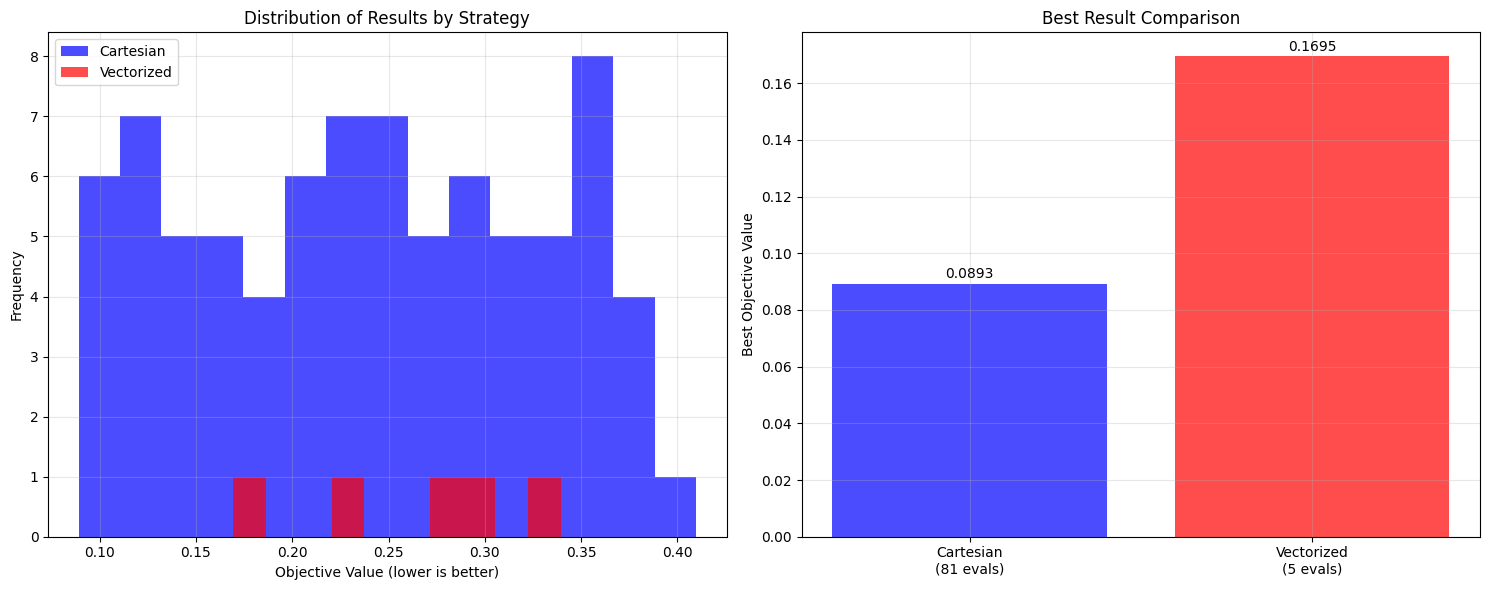


=== STRATEGY COMPARISON ===
Cartesian Strategy:
  - Evaluations: 81
  - Best value: 0.089279
  - Coverage: Exhaustive (all combinations)

Vectorized Strategy:
  - Evaluations: 5
  - Best value: 0.169485
  - Coverage: Targeted (expert-guided combinations)

Efficiency: Vectorized used 6.2% of the evaluations


In [65]:
# Compare the two strategies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot results from both strategies
ax1.hist(results_cartesian['value'], bins=15, alpha=0.7, label='Cartesian', color='blue')
ax1.hist(results_vectorized['value'], bins=10, alpha=0.7, label='Vectorized', color='red')
ax1.set_xlabel('Objective Value (lower is better)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Results by Strategy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Compare best results
strategies = ['Cartesian\n(81 evals)', 'Vectorized\n(5 evals)']
best_values = [results_cartesian['value'][0], results_vectorized['value'][0]]
colors = ['blue', 'red']

bars = ax2.bar(strategies, best_values, color=colors, alpha=0.7)
ax2.set_ylabel('Best Objective Value')
ax2.set_title('Best Result Comparison')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, best_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n=== STRATEGY COMPARISON ===")
print(f"Cartesian Strategy:")
print(f"  - Evaluations: {len(results_cartesian['value'])}")
print(f"  - Best value: {results_cartesian['value'][0]:.6f}")
print(f"  - Coverage: Exhaustive (all combinations)")
print(f"\nVectorized Strategy:")
print(f"  - Evaluations: {len(results_vectorized['value'])}")
print(f"  - Best value: {results_vectorized['value'][0]:.6f}")
print(f"  - Coverage: Targeted (expert-guided combinations)")
print(f"\nEfficiency: Vectorized used {len(results_vectorized['value'])/len(results_cartesian['value']):.1%} of the evaluations")

In [66]:
# Clean up results directories results_cartesian and results_vectorized
if os.path.exists("results_cartesian"):
    shutil.rmtree("results_cartesian")
if os.path.exists("results_vectorized"):
    shutil.rmtree("results_vectorized")

## 2. Resume Functionality

For long-running searches, you can save progress and resume later using the `old_results` parameter.

In [67]:
def expensive_objective(x, y, z):
    """
    Simulate an expensive objective function that takes time to compute.
    """
    # Simulate computation time
    time.sleep(0.1)  # 100ms per evaluation
    
    # Complex objective with multiple local minima
    result = (x**2 + y**2 - z**2)**2 + jnp.sin(3*x) * jnp.cos(3*y) * jnp.exp(-z**2)
    
    return {
        "value": result,
        "computation_time": 0.1  # Track computation time
    }

# Define a moderately large search space
resume_search_space = {
    "x": jnp.linspace(-2, 2, 8),
    "y": jnp.linspace(-2, 2, 8),
    "z": jnp.linspace(0, 2, 4)
}

total_combinations = 8 * 8 * 4
print(f"Total combinations: {total_combinations}")
print(f"Estimated time: {total_combinations * 0.1:.1f} seconds")

Total combinations: 256
Estimated time: 25.6 seconds


### Initial Search (Partial)

In [68]:
# Clean up previous results
if os.path.exists("results_resume"):
    shutil.rmtree("results_resume")

# Run initial search with small batch size to simulate interruption
print("Starting initial search (will be 'interrupted')...")

grid_initial = DistributedGridSearch(
    objective_fn=expensive_objective,
    search_space=resume_search_space,
    batch_size=32,  # Small batches to simulate interruption
    progress_bar=True,
    result_dir="results_resume"
)

start_time = time.time()
grid_initial.run()
initial_time = time.time() - start_time

# Check what we have so far
result_files = glob.glob("results_resume/*.pkl")
print(f"\nInitial search completed in {initial_time:.1f} seconds")
print(f"Created {len(result_files)} result files")

# Load partial results
initial_results = grid_initial.stack_results("results_resume")
print(f"Completed {len(initial_results['value'])}/{total_combinations} evaluations")
print(f"Progress: {len(initial_results['value'])/total_combinations:.1%}")

Starting initial search (will be 'interrupted')...
Process 0 will process 256 combinations with batch size 32


Processing batches on device 0/1: 100%|██████████| 8/8 [00:01<00:00,  6.73it/s]



Initial search completed in 1.2 seconds
Created 8 result files
Loading from 0 to 8 (batch size 8)


Converting to arrays: 100%|██████████| 5/5 [00:00<00:00, 25.40it/s]


Completed 256/256 evaluations
Progress: 100.0%


### Expanding Search Space and Resuming

In [69]:
# Now let's expand the search space and resume from where we left off
expanded_search_space = {
    "x": jnp.linspace(-2, 2, 10),  # Increased from 8 to 10
    "y": jnp.linspace(-2, 2, 10),  # Increased from 8 to 10
    "z": jnp.linspace(0, 2, 5)     # Increased from 4 to 5
}

new_total = 10 * 10 * 5
print(f"Expanded search space: {new_total} total combinations")

# Create new grid search with old results to resume
print("\nResuming with expanded search space...")

grid_resumed = DistributedGridSearch(
    objective_fn=expensive_objective,
    search_space=expanded_search_space,
    old_results=initial_results,  # Pass previous results to skip completed evaluations
    batch_size=64,
    progress_bar=True,
    result_dir="results_resume"  # Same directory
)

print(f"Combinations remaining after filtering: {len(grid_resumed.combinations)}")

start_time = time.time()
grid_resumed.run()
resume_time = time.time() - start_time

print(f"Resume search completed in {resume_time:.1f} seconds")

Expanded search space: 500 total combinations

Resuming with expanded search space...
Reducing search space from 500 to 

100%|██████████| 500/500 [00:19<00:00, 25.90it/s]


492
Process 0 will process 492 combinations with batch size 64
Combinations remaining after filtering: 492


Processing batches on device 0/1: 100%|██████████| 8/8 [00:01<00:00,  6.53it/s]

Resume search completed in 1.2 seconds


### Final Results Analysis

Loading from 0 to 16 (batch size 16)


Converting to arrays: 100%|██████████| 5/5 [00:00<00:00, 86.82it/s]


=== RESUME FUNCTIONALITY SUMMARY ===
Initial evaluations: 256
Final evaluations: 748
New evaluations: 492

Total time: 2.4 seconds
Time saved by resuming: Avoided re-computing 256 evaluations

Best result:
  x = -0.667
  y = 0.222
  z = 0.500
  value = -0.497083


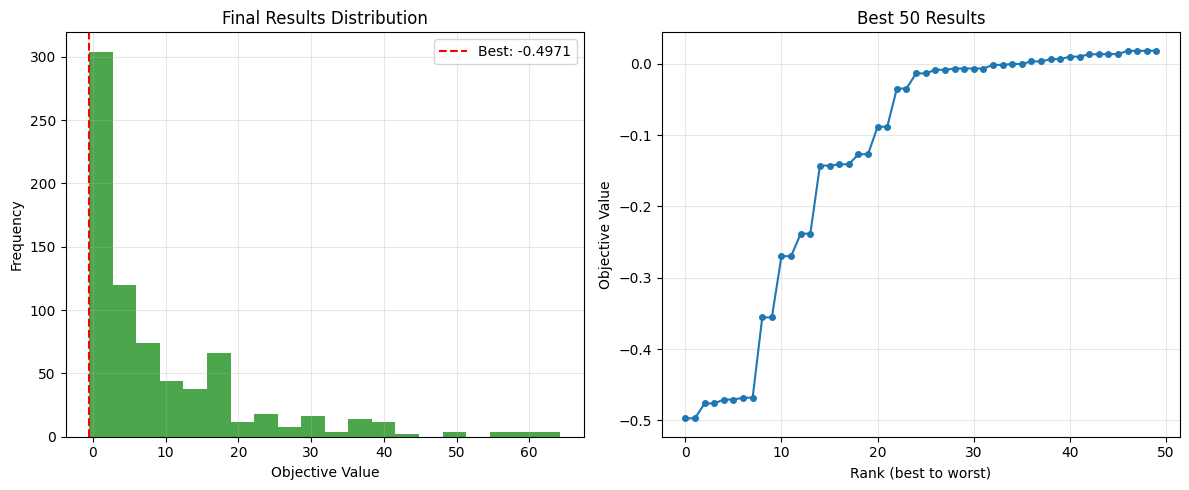

In [70]:
# Load final results
final_results = grid_resumed.stack_results("results_resume")

print("=== RESUME FUNCTIONALITY SUMMARY ===")
print(f"Initial evaluations: {len(initial_results['value'])}")
print(f"Final evaluations: {len(final_results['value'])}")
print(f"New evaluations: {len(final_results['value']) - len(initial_results['value'])}")
print(f"\nTotal time: {initial_time + resume_time:.1f} seconds")
print(f"Time saved by resuming: Avoided re-computing {len(initial_results['value'])} evaluations")

# Best result
best_idx = 0
print(f"\nBest result:")
print(f"  x = {final_results['x'][best_idx]:.3f}")
print(f"  y = {final_results['y'][best_idx]:.3f}")
print(f"  z = {final_results['z'][best_idx]:.3f}")
print(f"  value = {final_results['value'][best_idx]:.6f}")

# Visualize the search progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(final_results['value'], bins=20, alpha=0.7, color='green')
plt.axvline(final_results['value'][0], color='red', linestyle='--', 
           label=f'Best: {final_results["value"][0]:.4f}')
plt.xlabel('Objective Value')
plt.ylabel('Frequency')
plt.title('Final Results Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show progress over "time" (evaluation index)
sorted_values = jnp.sort(final_results['value'])
plt.plot(sorted_values[:50], 'o-', markersize=4)
plt.xlabel('Rank (best to worst)')
plt.ylabel('Objective Value')
plt.title('Best 50 Results')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [71]:
# Cleanup results directory
if os.path.exists("results_resume"):
    shutil.rmtree("results_resume")

## 3. Multi-Dimensional Data

Grid search supports multi-dimensional parameter arrays, where each parameter can be a matrix instead of a scalar. This is useful for optimizing structured parameters like filter kernels, weight matrices, or spatial configurations.

Let's demonstrate this with an image filter optimization example.

## 3.1 Multi-Dimensional Parameter Example

In [72]:
# Define multi-dimensional search space
# Each parameter is a set of 2D arrays that will be optimized
multidim_search_space = {
    # Different kernel configurations (each is a 2x2 matrix)
    "kernel_x": jnp.array([
        [[1.0, 0.5], [0.0, 1.0]],    # Edge detection kernel
        [[-1.0, 0.0], [0.0, -1.0]],  # Negative edge kernel  
        [[0.5, 0.5], [0.5, 0.5]],    # Smoothing kernel
        [[1.0, -1.0], [-1.0, 1.0]]   # Diagonal kernel
    ]),
    
    "kernel_y": jnp.array([
        [[0.0, 1.0], [1.0, 0.0]],    # Orthogonal kernel
        [[1.0, 1.0], [0.0, 0.0]],    # Horizontal kernel
        [[0.25, 0.75], [0.75, 0.25]], # Mixed kernel
        [[-0.5, 0.5], [0.5, -0.5]]   # Alternating kernel
    ]),
    
    # Bias matrices (2x2)
    "bias_matrix": jnp.array([
        [[0.1, 0.1], [0.1, 0.1]],    # Uniform small bias
        [[0.0, 0.2], [0.2, 0.0]],    # Diagonal bias
        [[0.05, 0.15], [0.15, 0.05]], # Gradient bias
        [[0.3, 0.0], [0.0, 0.3]]     # Corner bias
    ]),
    
    # Weight matrices (2x2)  
    "weight_matrix": jnp.array([
        [[1.0, 1.0], [1.0, 1.0]],    # Uniform weights
        [[2.0, 0.5], [0.5, 2.0]],    # Diagonal emphasis
        [[1.5, 0.8], [0.8, 1.5]],    # Symmetric weights
        [[0.7, 1.3], [1.3, 0.7]]     # Anti-diagonal weights
    ])
}

print("Multi-dimensional search space defined:")
for param_name, param_values in multidim_search_space.items():
    print(f"  {param_name}: {param_values.shape} (4 different {param_values.shape[1:]} matrices)")
    
print(f"\\nTotal combinations: {len(multidim_search_space['kernel_x'])} (Cartesian product)")

Multi-dimensional search space defined:
  kernel_x: (4, 2, 2) (4 different (2, 2) matrices)
  kernel_y: (4, 2, 2) (4 different (2, 2) matrices)
  bias_matrix: (4, 2, 2) (4 different (2, 2) matrices)
  weight_matrix: (4, 2, 2) (4 different (2, 2) matrices)
\nTotal combinations: 4 (Cartesian product)


In [73]:
def image_filter_objective(kernel_x, kernel_y, bias_matrix, weight_matrix):
    """
    Image filter optimization with multi-dimensional parameters.
    
    Each parameter is a 2D array representing filter components.
    Returns both scalar and element-wise results for demonstration.
    """
    # Simulate filter response - combine kernels with bias and weights
    response = kernel_x**2 + kernel_y**2 - bias_matrix**2 + 0.1 * weight_matrix
    
    # Add interaction terms between parameters
    interaction = jnp.sum(kernel_x * kernel_y) + jnp.sum(bias_matrix * weight_matrix)
    
    # Compute both scalar and non-scalar objectives
    scalar_objective = response.sum() + interaction
    
    return {
        "value": scalar_objective,          # Scalar for optimization
        "response_map": response,           # Element-wise response
        "interaction": interaction,         # Cross-parameter interaction
        "kernel_norm": jnp.linalg.norm(kernel_x) + jnp.linalg.norm(kernel_y)
    }

# Test with sample 2D parameters
sample_kernel = jnp.array([[1, 2], [3, 4]])
sample_bias = jnp.array([[0.1, 0.2], [0.3, 0.4]])
test_result = image_filter_objective(sample_kernel, sample_kernel, sample_bias, sample_bias)
print("Multi-dimensional parameter test:")
print(f"  Scalar objective: {test_result['value']}")
print(f"  Response map shape: {test_result['response_map'].shape}")
print(f"  Interaction term: {test_result['interaction']}")
print(f"  Kernel norm: {test_result['kernel_norm']}")

Multi-dimensional parameter test:
  Scalar objective: 90.10000610351562
  Response map shape: (2, 2)
  Interaction term: 30.299999237060547
  Kernel norm: 10.954451560974121


In [74]:
# Clean up and run multi-dimensional grid search
if os.path.exists("results_multidim"):
    shutil.rmtree("results_multidim")

grid_multidim = DistributedGridSearch(
    objective_fn=image_filter_objective,
    search_space=multidim_search_space,
    progress_bar=True,
    result_dir="results_multidim",
    batch_size=10  # Process 10 combinations at a time
)

print("Running multi-dimensional grid search...")
grid_multidim.run()
results_multidim = grid_multidim.stack_results("results_multidim")

print(f"\nCompleted {len(results_multidim['value'])} evaluations")

# Show results structure with multi-dimensional parameters
print(f"\nResults keys: {list(results_multidim.keys())}")
print("Parameter shapes in results:")
for param in ["kernel_x", "kernel_y", "bias_matrix", "weight_matrix"]:
    if param in results_multidim:
        print(f"  {param}: {results_multidim[param].shape}")

# Best result analysis
best_idx = 0
print(f"\nBest result (index {best_idx}):")
print(f"  Objective value: {results_multidim['value'][best_idx]:.4f}")
print(f"  Kernel X: {results_multidim['kernel_x'][best_idx]}")
print(f"  Kernel Y: {results_multidim['kernel_y'][best_idx]}")
print(f"  Bias matrix: {results_multidim['bias_matrix'][best_idx]}")
print(f"  Weight matrix: {results_multidim['weight_matrix'][best_idx]}")
print(f"  Interaction: {results_multidim['interaction'][best_idx]:.4f}")
print(f"  Kernel norm: {results_multidim['kernel_norm'][best_idx]:.4f}")

print(f"\nNote: Each parameter value corresponds to one row of the original search space matrix.")

Process 0 will process 256 combinations with batch size 10
Running multi-dimensional grid search...


Processing batches on device 0/1: 100%|██████████| 26/26 [00:00<00:00, 61.12it/s]


Loading from 0 to 26 (batch size 26)


Converting to arrays: 100%|██████████| 8/8 [00:00<00:00, 291.12it/s]


Completed 256 evaluations

Results keys: ['kernel_x', 'kernel_y', 'bias_matrix', 'weight_matrix', 'interaction', 'kernel_norm', 'response_map', 'value']
Parameter shapes in results:
  kernel_x: (256, 2, 2)
  kernel_y: (256, 2, 2)
  bias_matrix: (256, 2, 2)
  weight_matrix: (256, 2, 2)

Best result (index 0):
  Objective value: 2.6200
  Kernel X: [[0.5 0.5]
 [0.5 0.5]]
  Kernel Y: [[-0.5  0.5]
 [ 0.5 -0.5]]
  Bias matrix: [[0.  0.2]
 [0.2 0. ]]
  Weight matrix: [[2.  0.5]
 [0.5 2. ]]
  Interaction: 0.2000
  Kernel norm: 2.0000

Note: Each parameter value corresponds to one row of the original search space matrix.


## 3.2 Multi-Dimensional output Example

You can also have multi-dimensional outputs, such as images or matrices. The library can handle these cases seamlessly.
The results will be sorted in order of best (least value) to worst (most value) based on the loss function in case of scalar output.

In case of multi-dimensional output, the results will be sorted with the mean of the output values.

In [75]:
def multi_dim_output_objective(kernel_x, kernel_y, bias_matrix, weight_matrix):
    """
    Multi-dimensional output objective function.
    
    Returns 2D arrays as values instead of scalars or 1D arrays.
    Useful for spatial optimization, image processing, and multi-channel analysis.
    """
    # Compute 2D response map
    response = kernel_x**2 + kernel_y**2 - bias_matrix**2 + 0.1 * weight_matrix
    
    # Compute 3D multi-channel response (simulate RGB channels)
    red_channel = response * 1.2    # Enhanced response
    green_channel = response * 0.8  # Reduced response  
    blue_channel = response * 1.0   # Normal response
    
    multi_channel = jnp.stack([red_channel, green_channel, blue_channel], axis=-1)
    
    return {
        "value": response,  # 2D array output - sorted by mean of all elements
        "multi_channel": multi_channel,  # 3D array for additional analysis
        "mean_response": response.mean(),
        "max_response": response.max(),
        "min_response": response.min(),
        "response_std": response.std(),
        "total_energy": response.sum(),
        "kernel_norm": jnp.linalg.norm(kernel_x) + jnp.linalg.norm(kernel_y)
    }

# Test the function with sample data
sample_kernel = jnp.array([[1, 2], [3, 4]])
sample_bias = jnp.array([[0.1, 0.2], [0.3, 0.4]])

print("Multi-dimensional output test:")
test_result = multi_dim_output_objective(sample_kernel, sample_kernel, sample_bias, sample_bias)
print(f"  Value shape (2D): {test_result['value'].shape}")
print(f"  Value array:\\n{test_result['value']}")
print(f"  Multi-channel shape (3D): {test_result['multi_channel'].shape}")
print(f"  Mean (used for sorting): {test_result['value'].mean():.4f}")
print(f"  Total elements in value: {test_result['value'].size}")
print("  ✓ Multi-dimensional output function ready!")

Multi-dimensional output test:
  Value shape (2D): (2, 2)
  Value array:\n[[ 2.        7.98    ]
 [17.94     31.880001]]
  Multi-channel shape (3D): (2, 2, 3)
  Mean (used for sorting): 14.9500
  Total elements in value: 4
  ✓ Multi-dimensional output function ready!


In [76]:
# Run multi-dimensional output grid search
print("=== MULTI-DIMENSIONAL OUTPUT GRID SEARCH ===\\n")

# Use smaller search space for demonstration
demo_multidim_space = {
    "kernel_x": jnp.array([
        [[1.0, 0.5], [0.0, 1.0]],    # Configuration 1
        [[-1.0, 0.0], [0.0, -1.0]],  # Configuration 2
        [[0.5, 0.5], [0.5, 0.5]]     # Configuration 3
    ]),
    "kernel_y": jnp.array([
        [[0.0, 1.0], [1.0, 0.0]],    # Configuration 1
        [[1.0, 1.0], [0.0, 0.0]],    # Configuration 2
        [[0.25, 0.75], [0.75, 0.25]] # Configuration 3
    ]),
    "bias_matrix": jnp.array([
        [[0.1, 0.1], [0.1, 0.1]],    # Configuration 1
        [[0.0, 0.2], [0.2, 0.0]],    # Configuration 2
        [[0.05, 0.15], [0.15, 0.05]] # Configuration 3
    ]),
    "weight_matrix": jnp.array([
        [[1.0, 1.0], [1.0, 1.0]],    # Configuration 1
        [[2.0, 0.5], [0.5, 2.0]],    # Configuration 2
        [[1.5, 0.8], [0.8, 1.5]]     # Configuration 3
    ])
}

print(f"Search space: {3**4} = {3**4} total combinations")
print("Each result will contain 2D response maps (2x2 matrices)\\n")

# Clean up and run multi-dimensional output search
if os.path.exists("results_multidim_output"):
    shutil.rmtree("results_multidim_output")

grid_multidim_output = DistributedGridSearch(
    objective_fn=multi_dim_output_objective,
    search_space=demo_multidim_space,
    progress_bar=True,
    result_dir="results_multidim_output",
    batch_size=10  # Process 10 combinations at a time
)

print("Running multi-dimensional OUTPUT grid search...")
grid_multidim_output.run()
results_multidim_output = grid_multidim_output.stack_results("results_multidim_output")

print(f"\\n=== RESULTS ANALYSIS ===")
print(f"Total evaluations: {len(results_multidim_output['value'])}")
print(f"Value array shape: {results_multidim_output['value'].shape}")
print(f"Multi-channel shape: {results_multidim_output['multi_channel'].shape}")

# Show best results
print("\\nTop 3 results (sorted by mean of 2D response map):")
for i in range(3):
    response_2d = results_multidim_output['value'][i]
    mean_val = response_2d.mean()
    print(f"  Rank {i+1}: mean={mean_val:.4f}")
    print(f"         2D response:\\n         {response_2d}")
    print(f"         stats: min={response_2d.min():.3f}, max={response_2d.max():.3f}, std={response_2d.std():.3f}")

# Clean up
if os.path.exists("results_multidim_output"):
    shutil.rmtree("results_multidim_output")

=== MULTI-DIMENSIONAL OUTPUT GRID SEARCH ===\n
Search space: 81 = 81 total combinations
Each result will contain 2D response maps (2x2 matrices)\n
Process 0 will process 81 combinations with batch size 10
Running multi-dimensional OUTPUT grid search...


Processing batches on device 0/1: 100%|██████████| 9/9 [00:00<00:00, 42.65it/s]


Loading from 0 to 9 (batch size 9)


Converting to arrays: 100%|██████████| 12/12 [00:00<00:00, 1977.67it/s]

\n=== RESULTS ANALYSIS ===
Total evaluations: 81
Value array shape: (81, 2, 2)
Multi-channel shape: (81, 2, 2, 3)
\nTop 3 results (sorted by mean of 2D response map):
  Rank 1: mean=0.6425
         2D response:\n         [[0.4125 0.8725]
 [0.8725 0.4125]]
         stats: min=0.412, max=0.873, std=0.230
  Rank 2: mean=0.6500
         2D response:\n         [[0.41       0.89000005]
 [0.89000005 0.41      ]]
         stats: min=0.410, max=0.890, std=0.240
  Rank 3: mean=0.6525
         2D response:\n         [[0.4025     0.90250003]
 [0.90250003 0.4025    ]]
         stats: min=0.403, max=0.903, std=0.250


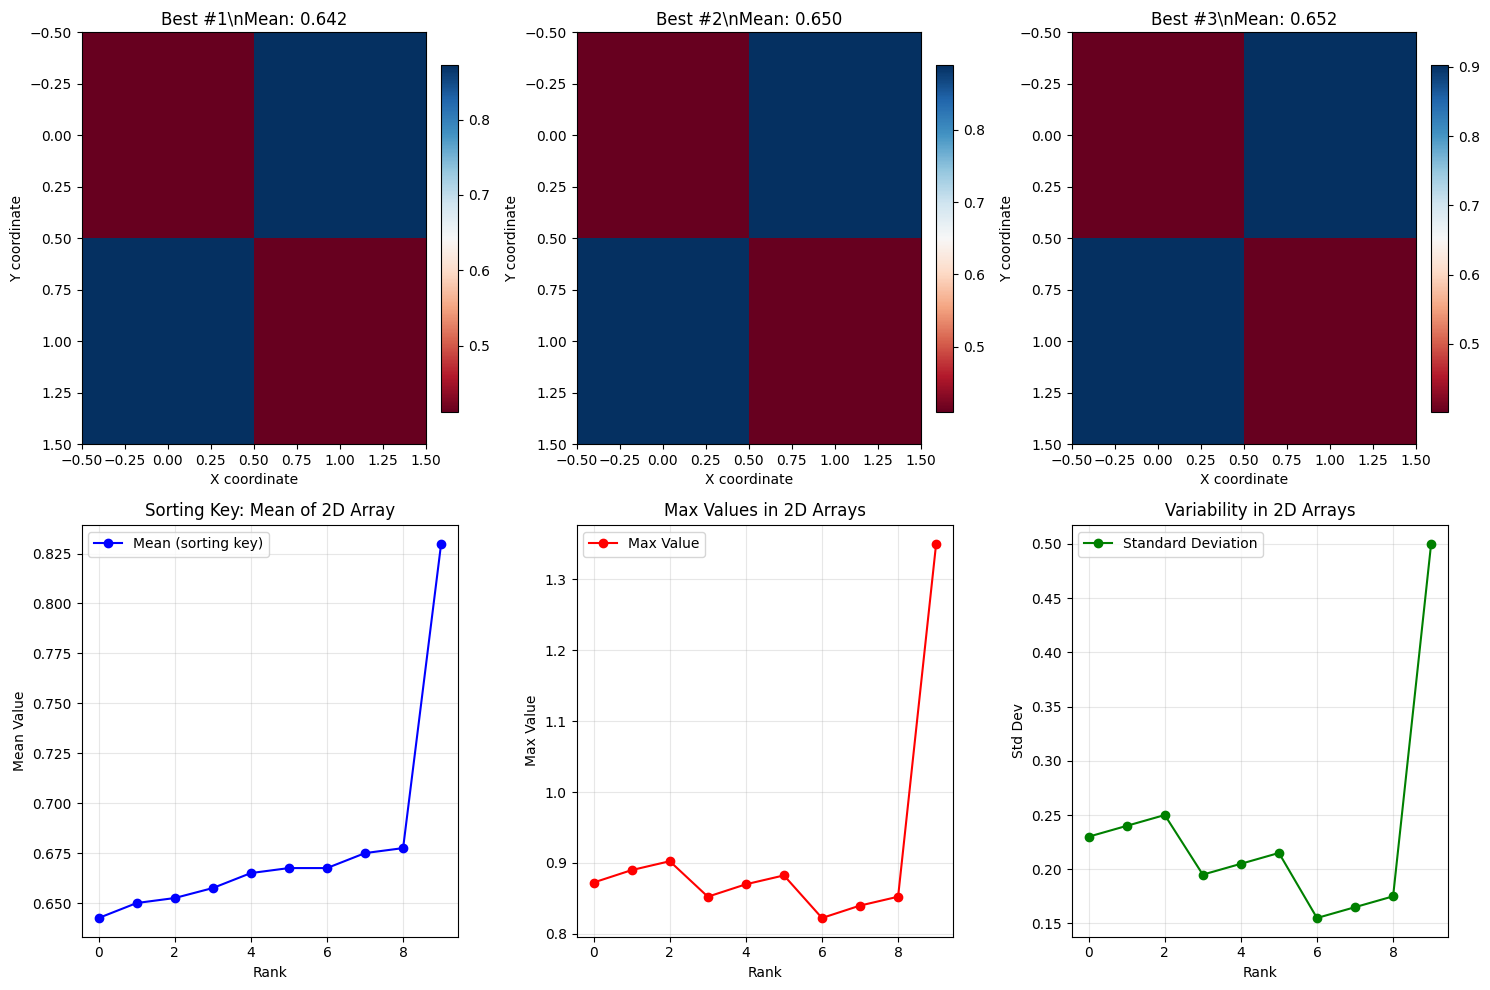

In [77]:
# Visualize multi-dimensional outputs
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot top 3 response maps
for i in range(3):
    response_2d = results_multidim_output['value'][i]
    im = axes[0, i].imshow(response_2d, cmap='RdBu', aspect='auto')
    axes[0, i].set_title(f'Best #{i+1}\\nMean: {response_2d.mean():.3f}')
    axes[0, i].set_xlabel('X coordinate')
    axes[0, i].set_ylabel('Y coordinate')
    plt.colorbar(im, ax=axes[0, i], fraction=0.046, pad=0.04)

# Plot statistics comparison
means = [val.mean() for val in results_multidim_output['value'][:10]]
maxs = [val.max() for val in results_multidim_output['value'][:10]]
stds = [val.std() for val in results_multidim_output['value'][:10]]

axes[1, 0].plot(means, 'o-', label='Mean (sorting key)', color='blue')
axes[1, 0].set_xlabel('Rank')
axes[1, 0].set_ylabel('Mean Value')
axes[1, 0].set_title('Sorting Key: Mean of 2D Array')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].plot(maxs, 'o-', label='Max Value', color='red')
axes[1, 1].set_xlabel('Rank')
axes[1, 1].set_ylabel('Max Value')
axes[1, 1].set_title('Max Values in 2D Arrays')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

axes[1, 2].plot(stds, 'o-', label='Standard Deviation', color='green')
axes[1, 2].set_xlabel('Rank')
axes[1, 2].set_ylabel('Std Dev')
axes[1, 2].set_title('Variability in 2D Arrays')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].legend()

plt.tight_layout()
plt.show()


In [78]:
# Clean up and remove previous results
if os.path.exists("results_multidim"):
    shutil.rmtree("results_multidim")